# <center> Trajectory of a particle under the action of a magnetic field </center>
<center> Trajetória de uma partícula sob ação de um campo magnético </center>

------------------------------------

This project is inspired by a proton accelerator system. Its purpose is to predict the trajectory of a proton as it passes through a magnetic dipole, which is used to alter its path. By adjusting particle and magnet parameters, this code can be applied to predict the motion of any particle in a magnetic field.

## 1. Imports

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from scipy.interpolate import RegularGridInterpolator
from datetime import datetime
import math
import warnings
warnings.filterwarnings("ignore")

## 2. Simulation parameters

### 2.1 Particle properties

In [70]:
''' ==== particle features ==== '''
m = 939.3      # mass (MeV/c²)
q = 1          # charge

### 2.2 Initial conditions

In [71]:
''' ==== initial conditions ==== '''
x0, y0, z0 = 0, 0, 0     # initial position (m)
v_direction = [1, 0, 0]
Ec0 = 0.01        # initial kinetic energy (MeV)

### 2.3 Time parameters

In [72]:
''' ==== time conditions ==== '''
step = 1e-11      # time step (used for RK4)
total_t = 1e-8    # total elapsed time (s)

### 2.4 Input data

In [73]:
''' ==== loading data ==== '''
file_name = "2017-03-06_BD-004_Model09_Hall_I=991.63A.dat"      # file containing the data to be uploaded
magnet_name = "BD-004"
magnet_type = "dipole"
traj_distance = 0.7

### 2.5 Output settings

In [74]:
''' ==== saving data ==== '''
output_file = True 
txt_name = "2017-03-06_BD-004_teste"


''' ==== graphic visualization ==== '''
output_graphic = True

## 3. Auxiliary functions

### 3.1 Eletric field 

In [75]:
def e_field(x, y, z): 
      Ex = 0
      Ey = 0
      Ez = 0
      return Ex, Ey, Ez

### 3.2 Magnetic field interpolation

In [76]:
# creates the interpolator
def create_interpolators(df):

    # each coordinate column needs to be sorted and a unique value of each coordinate is saved
    x_vals = np.sort(pd.to_numeric(df["x_mm"]).unique())
    y_vals = np.sort(df["y_mm"].unique())
    z_vals = np.sort(pd.to_numeric(df["z_mm"]).unique())

    # saves the number of different values of each coordinate
    nx, ny, nz = len(x_vals), len(y_vals), len(z_vals)

    # reshapes the field components into 3D grids
    fbx_grid = df['Bx_T'].values.reshape(nx, ny, nz)
    fby_grid = df['By_T'].values.reshape(nx, ny, nz)
    fbz_grid = df['Bz_T'].values.reshape(nx, ny, nz)

    # creates functions to define each field component
    fbx = RegularGridInterpolator((x_vals, y_vals, z_vals), fbx_grid, bounds_error=False, fill_value=None)
    fby = RegularGridInterpolator((x_vals, y_vals, z_vals), fby_grid, bounds_error=False, fill_value=None)
    fbz = RegularGridInterpolator((x_vals, y_vals, z_vals), fbz_grid, bounds_error=False, fill_value=None)
    
    return {
        'Bx': fbx,
        'By': fby,
        'Bz': fbz,
    }

### 3.3 Magnetic field

In [77]:
# defines the magnetic field at each point
def b_field(x, y, z, interp_data):

    # this transformation is only necessary when the data given is in mm
    x_mm = x * 1000
    y_mm = y * 1000
    z_mm = z * 1000

    # creates the point to be evaluated
    point = np.array([x_mm, y_mm, z_mm], dtype=float)

    # saves each component of the magnetic field
    Bx = float(interp_data['Bx'](point))
    By = float(interp_data['By'](point))
    Bz = float(interp_data['Bz'](point))
    
    return Bx, By, Bz

## 4. Main function

In [78]:
def main_func(m, q, x0, y0, z0, b_field, e_field, Ec0, v_direction, step, total_t, output_file, txt_name, file_name, magnet_name, magnet_type, traj_distance):

    # define some physical constants
    c = 2.99792458e8      # light speed (m/s)
    conv_m = m * 1.78266e-30      # converted mass (Kg)
    conv_q = q * 1.60218e-19        # converted charge (C)
    const = conv_q/conv_m
    gamma = 1.0 + (Ec0 / m)
    conv_v = (np.sqrt(1.0 - 1.0/(gamma**2))) * c  # converted speed (m/s)




    # convert and normalize velocity direction
    ux = v_direction[0]
    uy = v_direction[1]
    uz = v_direction[2]
    u = np.array([ux, uy, uz], dtype=float)
    u_hat = u / np.linalg.norm(u)
    Vx, Vy, Vz = conv_v * u_hat          # x, y and z velocitys (m/s)


    x, y, z = x0, y0, z0       # initial position




    # data import
    df = pd.read_csv(file_name, sep="\t", skiprows=15)   # skiprows=15 only in this case!
    # some adjusts (also only in this case!)
    df.drop(index=[0], inplace=True)
    df = df.dropna(axis=1)
    df = df.set_axis(["x_mm", "y_mm", "z_mm", "Bx_T", "By_T", "Bz_T"], axis=1)
    df = df.apply(pd.to_numeric, errors='coerce')
    df = df.dropna()




    # calls the interpolator function only once, so the code runs faster
    interp_data = create_interpolators(df)




    # instant acceleration function
    def acceleration(x, y, z, Vx, Vy, Vz):
        Bx, By, Bz = b_field(x, y, z, interp_data)
        Ex, Ey, Ez = e_field(x, y, z)

        V2 = Vx**2 + Vy**2 + Vz**2    # squared velocity

        # checks if particle's velocity is closer to light's (won't be)
        if V2 >= c**2:
            gamma_local = 1.0e10 
        else:
            gamma_local = 1.0 / np.sqrt(1.0 - V2/c**2)
    

        # applies Lorentz factor to Newton-Lorentz equations (defined at readme section)
        # defines instant acceleration based on instant velocitys and fields
        ax2 = const/gamma_local*((Ex+Vy*Bz-Vz*By)-((Vx/c**2)*Vx*Ex+Vy*Ey+Vz*Ez))
        ay2 = const/gamma_local*((Ey+Vz*Bx-Vx*Bz)-((Vy/c**2)*Vx*Ex+Vy*Ey+Vz*Ez))
        az2 = const/gamma_local*((Ez+Vx*By-Vy*Bx)-((Vz/c**2)*Vx*Ex+Vy*Ey+Vz*Ez))
        
        return ax2, ay2, az2
    



    # Runge-Kutta 4th order method
    def rk4(x, y, z, Vx, Vy, Vz, step): 
        # k1
        ax1, ay1, az1 = acceleration(x, y, z, Vx, Vy, Vz)

        k1_x = Vx        
        k1_y = Vy        
        k1_z = Vz         
        k1_Vx = ax1     
        k1_Vy = ay1      
        k1_Vz = az1        
    
        # k2 
        x2 = x + 0.5*step * k1_x
        y2 = y + 0.5*step * k1_y
        z2 = z + 0.5*step * k1_z
        Vx2 = Vx + 0.5*step * k1_Vx
        Vy2 = Vy + 0.5*step * k1_Vy
        Vz2 = Vz + 0.5*step * k1_Vz
    
        ax2, ay2, az2 = acceleration(x2, y2, z2, Vx2, Vy2, Vz2)
        k2_x = Vx2   
        k2_y = Vy2
        k2_z = Vz2
        k2_Vx = ax2
        k2_Vy = ay2
        k2_Vz = az2
    
        # k3 
        x3 = x + 0.5*step * k2_x
        y3 = y + 0.5*step * k2_y
        z3 = z + 0.5*step * k2_z
        Vx3 = Vx + 0.5*step * k2_Vx
        Vy3 = Vy + 0.5*step * k2_Vy
        Vz3 = Vz + 0.5*step * k2_Vz
    
        ax3, ay3, az3 = acceleration(x3, y3, z3, Vx3, Vy3, Vz3)
        k3_x = Vx3
        k3_y = Vy3
        k3_z = Vz3
        k3_Vx = ax3
        k3_Vy = ay3
        k3_Vz = az3
    
        # k4
        x4 = x + step * k3_x
        y4 = y + step * k3_y
        z4 = z + step * k3_z
        Vx4 = Vx + step * k3_Vx
        Vy4 = Vy + step * k3_Vy
        Vz4 = Vz + step * k3_Vz
    
        ax4, ay4, az4 = acceleration(x4, y4, z4, Vx4, Vy4, Vz4)
        k4_x = Vx4
        k4_y = Vy4
        k4_z = Vz4
        k4_Vx = ax4
        k4_Vy = ay4
        k4_Vz = az4
    
        # general solution
        new_x = x + (step/6.0) * (k1_x + 2*k2_x + 2*k3_x + k4_x)
        new_y = y + (step/6.0) * (k1_y + 2*k2_y + 2*k3_y + k4_y)
        new_z = z + (step/6.0) * (k1_z + 2*k2_z + 2*k3_z + k4_z)
        new_Vx = Vx + (step/6.0) * (k1_Vx + 2*k2_Vx + 2*k3_Vx + k4_Vx)
        new_Vy = Vy + (step/6.0) * (k1_Vy + 2*k2_Vy + 2*k3_Vy + k4_Vy)
        new_Vz = Vz + (step/6.0) * (k1_Vz + 2*k2_Vz + 2*k3_Vz + k4_Vz)
    
        return new_x, new_y, new_z, new_Vx, new_Vy, new_Vz
    



    # define arrays to store the results
    num_steps = int(total_t/step)
    x_vals = np.zeros(num_steps)
    y_vals = np.zeros(num_steps)
    z_vals = np.zeros(num_steps)
    Vx_vals = np.zeros(num_steps)
    Vy_vals = np.zeros(num_steps)
    Vz_vals = np.zeros(num_steps)
    t_vals = np.zeros(num_steps)
    Bx_vals = np.zeros(num_steps) 
    By_vals = np.zeros(num_steps)
    Bz_vals = np.zeros(num_steps)




    # main loop
    for i in range(num_steps):
        x_vals[i], y_vals[i], z_vals[i] = x, y, z                             # instant position
        Vx_vals[i], Vy_vals[i], Vz_vals[i] = Vx, Vy, Vz                       # instant velocity
        t_vals[i] = i*step                                                    # instant of time
        Bx_vals[i], By_vals[i], Bz_vals[i] = b_field(x, y, z, interp_data)    # instant magnetic field
    
        x, y, z, Vx, Vy, Vz = rk4(x, y, z, Vx, Vy, Vz, step)




    # combine data into a single array
    data = np.column_stack((x_vals, y_vals, z_vals, Vx_vals, Vy_vals, Vz_vals, Bx_vals, By_vals, Bz_vals, t_vals))




    df_save = pd.DataFrame(data, columns=['x(m)', 'y(m)', 'z(m)', 'Vx(m/s)', 'Vy(m/s)', 'Vz(m/s)', 'Bx(T)', 'By(T)', 'Bz(T)', 't(s)'])
    




    # save data to file
    if output_file == True:
        df_save.to_csv(f"{txt_name}.csv", index=False, float_format='%.12e')
        simulation_params = {
        'magnet_name': f'{magnet_name}',
        'magnet_type': f'{magnet_type}',
        'timestamp': datetime.now().strftime('%Y-%m-%d_%H-%M-%S'),
        'filename': f'{txt_name}',
        '': '',
        'distance traveled[m]': f'{traj_distance}',
        '': '', 
        'particle_mass[MeV/c²]': f'{m}',
        'particle_charge[e]': f'{q}',
        'initial_kinetic_energy[MeV]': f'{Ec0}',
        'initial_position[m]': f'({x0}, {y0}, {z0})',
        'initial_velocity_direction': f'{v_direction}',
        'initial_speed[m/s]': f'{conv_v:.4e}',
        'time_step[s]': f'{step:.2e}',
        'total_time[s]': f'{total_t:.2e}',
        '': '',
        'Data columns': 'x(m), y(m), z(m), Vx(m/s), Vy(m/s), Vz(m/s), Bx(T), By(T), Bz(T), t(s)'
        }
        header_lines = []
        for key, value in simulation_params.items():
            if key == '':
               header_lines.append('')
            elif key == 'Data columns':
                header_lines.append(f'{value}')
            else:
             header_lines.append(f'{key}: {value}')
        header_str = '\n'.join(header_lines)
        np.savetxt(f"{txt_name}.txt", data, 
                fmt='%.12e', delimiter=',', 
                header=header_str,
                 comments='# ',
                 encoding='utf-8')




    # plot the results
    if output_graphic == True:
        x_list = df_save['x(m)']
        y_list = df_save['y(m)']
        z_list = df_save['z(m)']
        x_range = x_list.max() - x_list.min()
        y_range = y_list.max() - y_list.min()
        z_range = z_list.max() - z_list.min()

        fig = plt.figure(figsize=(15, 15))

        ax1 = fig.add_subplot(321) 
        ax2 = fig.add_subplot(322) 

        tempo = np.linspace(0, total_t, len(df_save))

        ax1.plot(df_save['x(m)'], df_save['y(m)'], 'palevioletred', linewidth=1.5)
        ax1.set_xlabel('X (m)')
        ax1.set_ylabel('Y (m)')
        ax1.grid(True)
        ax1.axis()
        ax1.set_title('XY trajectory')

        ax2.plot(tempo, df_save['z(m)'], 'teal', linewidth=1.5)
        ax2.set_xlabel('Tempo')
        ax2.set_ylabel('Z(m)')
        ax2.grid(True)
        ax2.set_title('Z trajectory')
        plt.tight_layout()
        plt.show()



        fig = go.Figure()
        fig.add_trace(go.Scatter3d(
            x=df_save['x(m)'],
            y=df_save['y(m)'],
            z=df_save['z(m)'],
            mode='markers'
        ))
        # set axis ranges properly using axis dicts and df_save columns
        fig.update_layout(
            title='3D Trajectory',
            scene=dict(
                xaxis=dict(title='x (m)'),
                yaxis=dict(title='y (m)'),
                zaxis=dict(title='z (m)'),
                camera=dict(
                    eye=dict(x=1.5, y=1.5, z=1.5)
                )
            ),
            width=800,
            height=600,
            margin=dict(r=20, l=10, b=10, t=40)
        )
        fig.show()




        # calculte the deviation degree
        angle01 = math.atan(z_range/x_range)
        degree_angle01 = math.degrees(angle01)

        angle02 = math.atan(y_range/x_range)
        degree_angle02 = math.degrees(angle02)

        print(f'The deviation degree (vertical) is approximately {degree_angle01:.2f}° ({degree_angle01})')
        print(f'The deviation degree (horizontal y-axis) is approximately {degree_angle02:.2f}° ({degree_angle02})')

## 5. Simulation execution

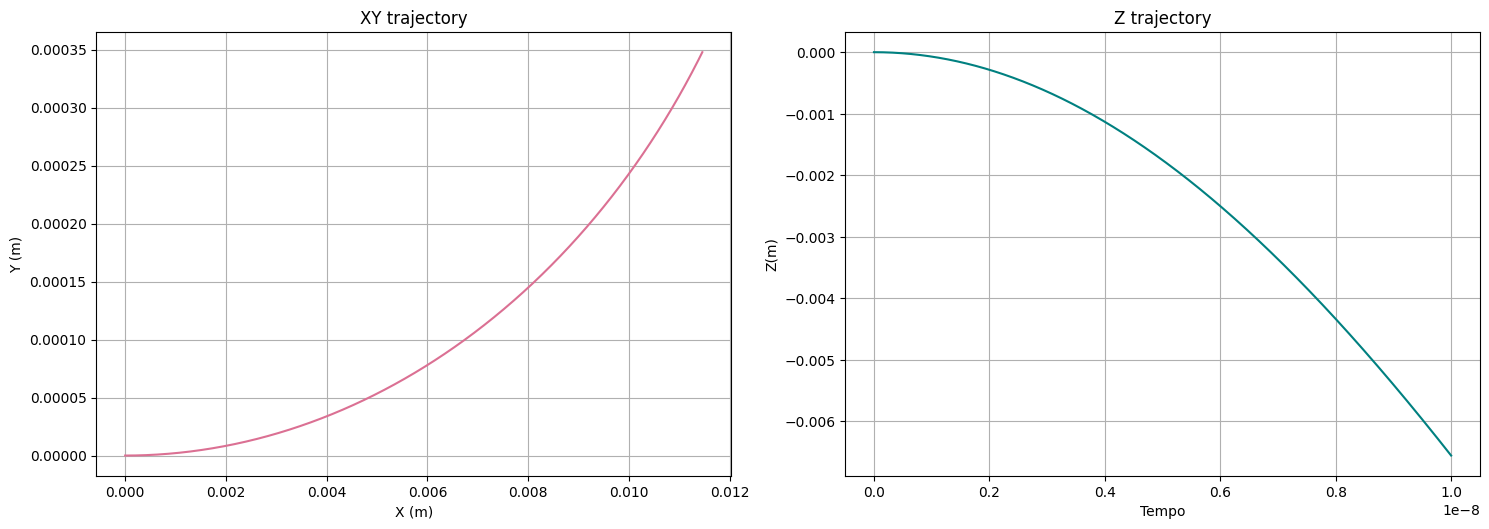

The deviation degree (vertical) is approximately 29.78° (29.775352588281695)
The deviation degree (horizontal y-axis) is approximately 1.74° (1.7383125782048148)


In [79]:
# run the simulation
main_func(m, q, x0, y0, z0, b_field, e_field, Ec0, v_direction, step, total_t, output_file, txt_name, file_name, magnet_name, magnet_type, traj_distance)